## **1. Setting up Kaggle API**

In [450]:
import os
os.environ['KAGGLE_USERNAME'] = "XXXXX"
os.environ['KAGGLE_KEY'] = "XXXXX"
!mkdir spotifydata
!kaggle datasets download -d maharshipandya/-spotify-tracks-dataset -p spotifydata
!unzip spotifydata/-spotify-tracks-dataset.zip -d spotifydata

mkdir: cannot create directory ‘spotifydata’: File exists
-spotify-tracks-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  spotifydata/-spotify-tracks-dataset.zip
replace spotifydata/dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## **2. Data Pre-processing**

*2.1 Loading of Data into Dataframe*

In [451]:
import pandas as pd
import numpy as np

df = pd.read_csv('spotifydata/dataset.csv')

df = df.dropna() #drop missing data 

df = df.drop(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name'], axis=1) #drop unnecessary columns



#separate numerical and categorical features
numerical_features = ['duration_ms',
                      'danceability',
                      'energy',
                      'loudness',
                      'speechiness',
                      'acousticness',
                      'instrumentalness',
                      'liveness',
                      'valence',
                      'tempo']

categorical_features = ['key',
                        'explicit',
                        'mode',
                        'track_genre',
                        'time_signature']

target = ['popularity']

print(df)


        popularity  duration_ms  explicit  danceability  energy  key  \
0               73       230666     False         0.676  0.4610    1   
1               55       149610     False         0.420  0.1660    1   
2               57       210826     False         0.438  0.3590    0   
3               71       201933     False         0.266  0.0596    0   
4               82       198853     False         0.618  0.4430    2   
...            ...          ...       ...           ...     ...  ...   
113995          21       384999     False         0.172  0.2350    5   
113996          22       385000     False         0.174  0.1170    0   
113997          22       271466     False         0.629  0.3290    0   
113998          41       283893     False         0.587  0.5060    7   
113999          22       241826     False         0.526  0.4870    1   

        loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0         -6.746     0       0.1430        0.0322     

*2.2 Encoding Categorical Variables*

In [452]:
X_num = df[numerical_features].values 

df['is_pop_or_hiphop'] = np.where(df['track_genre'].isin(['pop', 'hip-hop']), 1, 0) #combine genres into a binary variable 'is_pop_or_rap'

df.drop('track_genre', axis=1, inplace=True)

df = pd.get_dummies(df, columns=['explicit', 'key', 'time_signature'], drop_first=True) #one-hot encode the remaining categorical features

X_cat_df = df.drop(target + numerical_features, axis=1)
X_cat = X_cat_df.values


*2.3 Combining Numerical & Categorical Variables*

In [453]:
y = df[target].values 

X_num_cat = np.concatenate((X_num, X_cat), axis=1) #concatenate numerical and categorical features

print(X_num_cat)


[[2.30666e+05 6.76000e-01 4.61000e-01 ... 0.00000e+00 1.00000e+00
  0.00000e+00]
 [1.49610e+05 4.20000e-01 1.66000e-01 ... 0.00000e+00 1.00000e+00
  0.00000e+00]
 [2.10826e+05 4.38000e-01 3.59000e-01 ... 0.00000e+00 1.00000e+00
  0.00000e+00]
 ...
 [2.71466e+05 6.29000e-01 3.29000e-01 ... 0.00000e+00 1.00000e+00
  0.00000e+00]
 [2.83893e+05 5.87000e-01 5.06000e-01 ... 0.00000e+00 1.00000e+00
  0.00000e+00]
 [2.41826e+05 5.26000e-01 4.87000e-01 ... 0.00000e+00 1.00000e+00
  0.00000e+00]]


## **3. Ridge Regression**

In [454]:
import random

def ridge_regression(X, y, alpha):
    n_samples, n_features = X.shape
    XtX = X.transpose().dot(X) #dot product of X transposed and X
    inv_matrix = np.linalg.inv(XtX + alpha * np.eye(n_features)) #(XTX+λI)−1
    beta = inv_matrix.dot(X.transpose()).dot(y) #β̂ =(XTX+λI)−1.XTy
    return beta


train_ratio = 0.8 #splitting the dataset into train and test sets
n_samples = len(X_num)

n_train = int(train_ratio * n_samples) #calculate the number of samples for training and testing
n_test = n_samples - n_train

#generate random indices for training and testing
random.seed(1203) #set seed for consistency
indices = list(range(n_samples))
random.shuffle(indices)
train_indices = indices[:n_train]
test_indices = indices[n_train:]


## **4. Model Training**

*4.1 Numerical features only*

In [455]:
#split the numerical features into training and testing sets
X_num_train = X_num[train_indices]
y_train = y[train_indices]

X_num_test = X_num[test_indices]
y_test = y[test_indices]

alpha_values = np.round(np.arange(0, 10, 1), 1)

results = {}

#fit the Ridge Regression model for each alpha value and compute MSE
for alpha in alpha_values:
    coefficients = ridge_regression(X_num_train, y_train, alpha)
    y_pred = X_num_test.dot(coefficients)
    mse = np.sum((y_test - y_pred) ** 2) / n_test  #calculate MSE
    results[alpha] = {'coefficients': coefficients, 'mse': mse}

#display the coefficients and MSE for each alpha
for alpha, result in results.items():
    print("Alpha:", alpha)
    print("Coefficients:", result['coefficients'])
    print("MSE:", result['mse'])
    print()

min_alpha = min(results, key=lambda x: results[x]['mse'])
print("Alpha with minimum MSE:", min_alpha)

#compute mean mse 
mean_mse = np.mean([result['mse'] for result in results.values()])
print("Mean MSE:", mean_mse)


Alpha: 0
Coefficients: [[ 5.69205074e-06]
 [ 2.20404942e+01]
 [ 1.79312095e+01]
 [-6.89284704e-01]
 [-1.71768287e+01]
 [ 6.65078198e+00]
 [-1.05742322e+01]
 [ 1.98642600e+00]
 [-1.23196792e+01]
 [ 6.80009255e-02]]
MSE: 495.0890158501193

Alpha: 1
Coefficients: [[ 5.69956780e-06]
 [ 2.20305176e+01]
 [ 1.79230936e+01]
 [-6.89216246e-01]
 [-1.71529998e+01]
 [ 6.64734417e+00]
 [-1.05709334e+01]
 [ 1.98526763e+00]
 [-1.23103685e+01]
 [ 6.80323687e-02]]
MSE: 495.0891674492222

Alpha: 2
Coefficients: [[ 5.70707436e-06]
 [ 2.20205539e+01]
 [ 1.79149888e+01]
 [-6.89147876e-01]
 [-1.71292276e+01]
 [ 6.64391127e+00]
 [-1.05676384e+01]
 [ 1.98411384e+00]
 [-1.23010696e+01]
 [ 6.80637790e-02]]
MSE: 495.08933934092147

Alpha: 3
Coefficients: [[ 5.71457044e-06]
 [ 2.20106030e+01]
 [ 1.79068953e+01]
 [-6.89079594e-01]
 [-1.71055118e+01]
 [ 6.64048327e+00]
 [-1.05643473e+01]
 [ 1.98296460e+00]
 [-1.22917825e+01]
 [ 6.80951564e-02]]
MSE: 495.0895314171238

Alpha: 4
Coefficients: [[ 5.72205607e-06]
 [ 2.

*4.2 Numerical and Categorical features*

In [456]:
#split the numerical and categorical features into training and testing sets
X_num_cat_train = X_num_cat[train_indices]
y_train = y[train_indices]

X_num_cat_test = X_num_cat[test_indices]
y_test = y[test_indices]

alpha_values = np.round(np.arange(0, 10, 1), 1)

results = {}

#fit the Ridge Regression model for each alpha value and compute MSE
for alpha in alpha_values:
    coefficients = ridge_regression(X_num_cat_train, y_train, alpha)
    y_pred = X_num_cat_test.dot(coefficients)
    mse = np.mean((y_test - y_pred) ** 2)
    results[alpha] = {'coefficients': coefficients, 'mse': mse}

#display the coefficients and MSE for each alpha
for alpha, result in results.items():
    print("Alpha:", alpha)
    print("Coefficients:", result['coefficients'])
    print("MSE:", result['mse'])
    print()

min_alpha = min(results, key=lambda x: results[x]['mse'])
print("Alpha with minimum MSE:", min_alpha)

mean_mse = np.mean([result['mse'] for result in results.values()])
print("Mean MSE:", mean_mse)


Alpha: 0
Coefficients: [[-5.72774525e-07]
 [ 7.72847924e+00]
 [ 5.00149796e-02]
 [-4.88214601e-02]
 [-1.50971005e+01]
 [ 4.68269767e-01]
 [-8.11119369e+00]
 [ 1.67265772e+00]
 [-9.63720217e+00]
 [ 1.83451266e-02]
 [-2.15824257e-01]
 [ 8.24507275e+00]
 [ 3.46838918e+00]
 [ 1.35469962e+00]
 [ 2.56698253e+00]
 [ 1.09243646e+00]
 [ 2.51151552e+00]
 [ 1.03086475e+00]
 [ 1.52496004e+00]
 [ 5.61990050e-01]
 [ 1.05122172e+00]
 [ 9.46163303e-01]
 [ 8.95656240e-01]
 [ 1.83671964e+00]
 [ 2.89233948e+01]
 [ 2.82797826e+01]
 [ 3.16757387e+01]
 [ 2.82130056e+01]]
MSE: 482.44635705745924

Alpha: 1
Coefficients: [[-5.46601444e-07]
 [ 7.76640011e+00]
 [ 1.14064444e-01]
 [-5.13346642e-02]
 [-1.50895057e+01]
 [ 4.93483219e-01]
 [-8.11632193e+00]
 [ 1.67124651e+00]
 [-9.64089199e+00]
 [ 1.85407747e-02]
 [-2.10971599e-01]
 [ 8.24303347e+00]
 [ 3.46836137e+00]
 [ 1.36205973e+00]
 [ 2.57525273e+00]
 [ 1.10216696e+00]
 [ 2.52071531e+00]
 [ 1.04078415e+00]
 [ 1.53374344e+00]
 [ 5.69926945e-01]
 [ 1.05929221e+0

## **5. 5-fold Cross-Validation**

Average MSE for each alpha:
Alpha: 0
Average MSE: 486.37122535610445

Alpha: 1
Average MSE: 486.3711936130171

Alpha: 2
Average MSE: 486.37171001707475

Alpha: 3
Average MSE: 486.37275231445

Alpha: 4
Average MSE: 486.3742991853687

Alpha: 5
Average MSE: 486.37633020055364

Alpha: 6
Average MSE: 486.3788257799386

Alpha: 7
Average MSE: 486.3817671535253

Alpha: 8
Average MSE: 486.385136324256

Alpha: 9
Average MSE: 486.3889160327876

Alpha: 10
Average MSE: 486.39308972405996

Best Alpha: 1


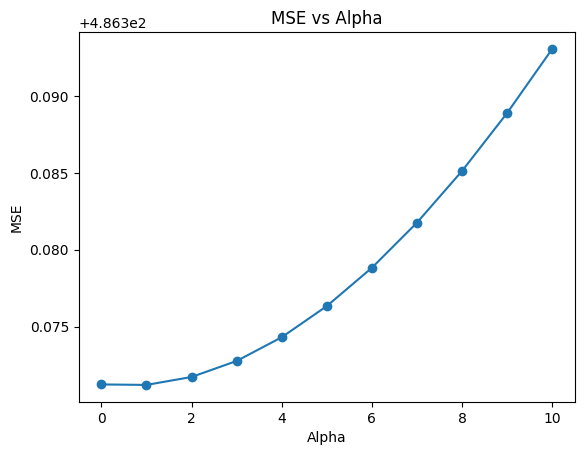

In [457]:
import matplotlib.pyplot as plt

k = 5

alpha_values = np.arange(0, 11)

mse_values = {alpha: [] for alpha in alpha_values} #create a dictionary to store the MSE for each alpha value

#5 fold CV
for fold in range(k):
    subsets = np.array_split(train_indices, k) #split the training indices into k subsets

    validation_indices = subsets[fold] #validation and training indices for the current fold
    training_indices = np.concatenate(subsets[:fold] + subsets[fold+1:])
    
    #split the data into training and validation sets based on the indices
    X_train = X_num_cat[training_indices]
    y_train = y[training_indices]
    X_val = X_num_cat[validation_indices]
    y_val = y[validation_indices]
    
    #fit the Ridge Regression model for each alpha value and compute MSE
    for alpha in alpha_values:
        coefficients = ridge_regression(X_train, y_train, alpha)
        y_pred = X_val.dot(coefficients)
        mse = np.mean((y_val - y_pred) ** 2)
        mse_values[alpha].append(mse)

#find average MSE across folds for each alpha value
average_mse_values = {alpha: np.mean(mse_values[alpha]) for alpha in alpha_values}

best_alpha = min(average_mse_values, key=average_mse_values.get) #determine the best alpha

#display the average MSE for each alpha value
print("Average MSE for each alpha:")
for alpha in average_mse_values:
    print("Alpha:", alpha)
    print("Average MSE:", average_mse_values[alpha])
    print()

print("Best Alpha:", best_alpha)

#plot the MSE against alpha
plt.plot(alpha_values, [average_mse_values[alpha] for alpha in alpha_values], marker='o')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('MSE vs Alpha')
plt.show()


## **6. Final Model**

*6.1 Coefficient Determination*

In [458]:
#fit the Ridge Regression model with the best alpha
best_fit = ridge_regression(X_train, y_train, best_alpha)

print("Best Alpha:", best_alpha)
coefficients = {}
for i, coeff in enumerate(best_fit):
    variable_name = numerical_features[i] if i < len(numerical_features) else X_cat_df.columns[i - len(numerical_features)]
    coefficients[variable_name] = float(coeff)
    print(variable_name, coefficients[variable_name])


Best Alpha: 1
duration_ms -4.2110531424848906e-07
danceability 7.888906978487383
energy 0.06031608831339669
loudness -0.04950311032356508
speechiness -15.205384557435497
acousticness 0.6157405198441221
instrumentalness -7.937752829398522
liveness 1.6388041823942339
valence -9.595497188867869
tempo 0.019590846571419733
mode -0.29217552397713004
is_pop_or_hiphop 8.534671307981561
explicit_True 3.5699066335682446
key_1 1.4933804869187244
key_2 2.5106451408925197
key_3 0.697371085911825
key_4 2.416664805230665
key_5 0.9919118172677783
key_6 1.4234501721254953
key_7 0.611028131012763
key_8 0.8006655790333852
key_9 0.9748449717569292
key_10 0.7880470495170817
key_11 1.821268658453009
time_signature_1 29.22498627314143
time_signature_3 27.982292696125313
time_signature_4 31.364799028291127
time_signature_5 27.705328156138894


6.2 Measuring Model Effectiveness

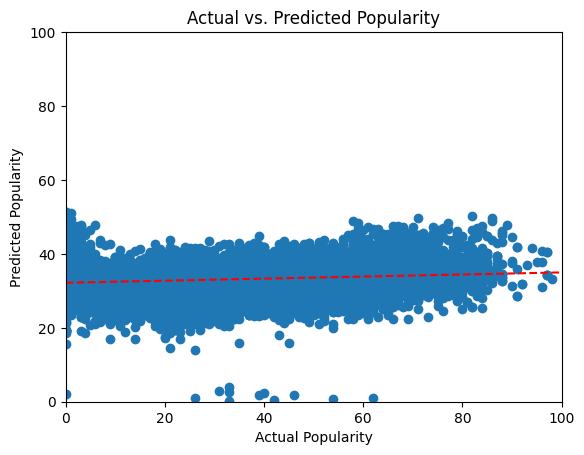

In [459]:
y_pred_final = X_num_cat_test.dot(best_fit)

#plot scatter plot of actual and predicted popularity
plt.scatter(y_test, y_pred_final)
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Actual vs. Predicted Popularity')
plt.xlim(0, 100)
plt.ylim(0, 100)

#fit a best fit line
best_fit_line = np.polyfit(y_test.flatten(), y_pred_final.flatten(), 1)
x = np.linspace(0, 100, 100)
y = best_fit_line[0] * x + best_fit_line[1]
plt.plot(x, y, color='red', linestyle='--')

plt.show()


*6.3 Checking Correlation of Variables*

<ipython-input-462-f64009601489>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df1.corr()


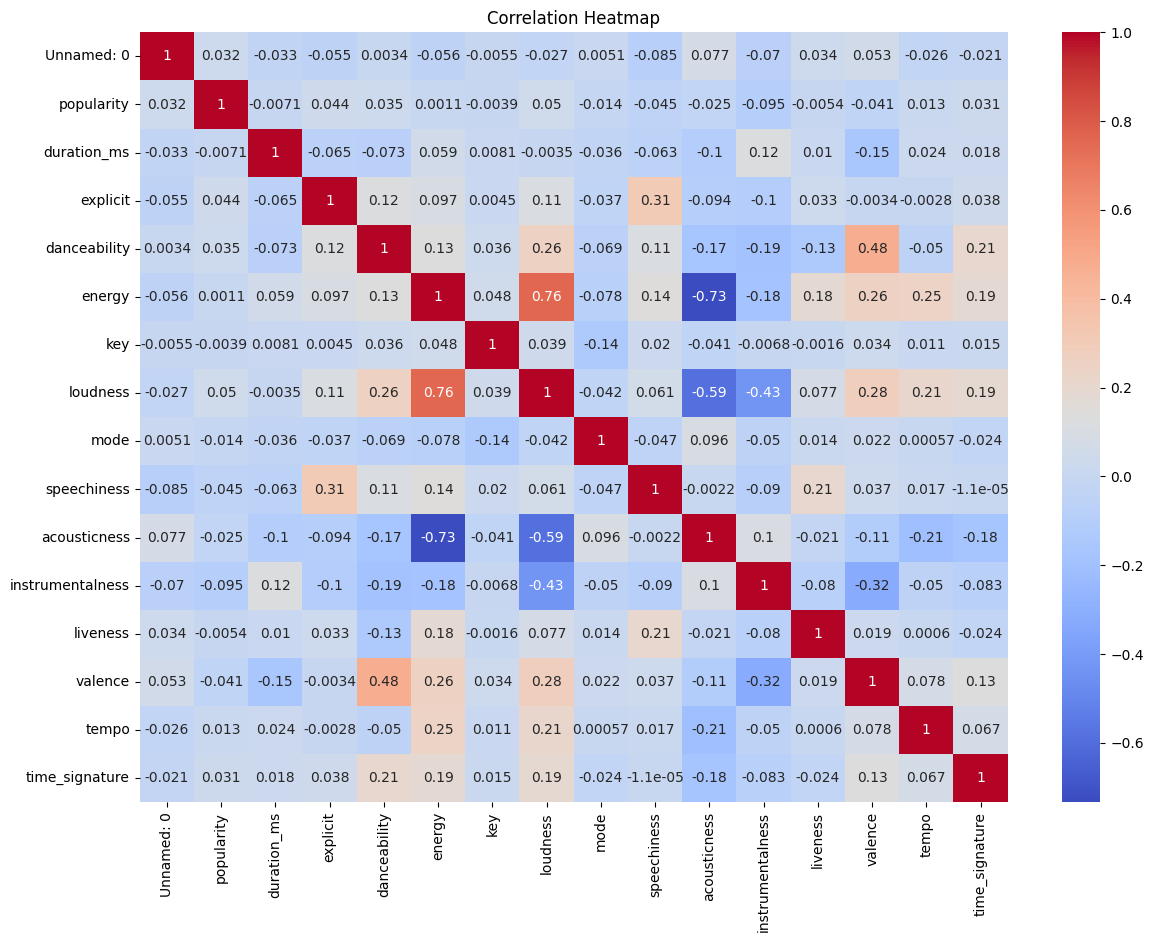

In [462]:
import seaborn as sns
import matplotlib.pyplot as plt
#create the correlation matrix
df1 = pd.read_csv('spotifydata/dataset.csv')
correlation_matrix = df1.corr()


#plot the heatmat
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()